In [1]:
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
from tabulate import tabulate

In [2]:
# Load the datasets
genome_scores = pd.read_csv('/Users/eeshan/Desktop/PC/miniproject ml/genome-scores.csv')
genome_tags = pd.read_csv('/Users/eeshan/Desktop/PC/miniproject ml/genome-tags.csv')
links = pd.read_csv('/Users/eeshan/Desktop/PC/miniproject ml/links.csv')
movies = pd.read_csv('/Users/eeshan/Desktop/PC/miniproject ml/movies.csv')
ratings = pd.read_csv('/Users/eeshan/Desktop/PC/miniproject ml/ratings.csv')
tags = pd.read_csv('/Users/eeshan/Desktop/PC/miniproject ml/tags.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# Function to display data types using tabulate
def display_data_types(df, table_name):
    data_types = df.dtypes.to_frame(name='Data Type').reset_index()
    data_types.columns = ['Column Name', 'Data Type']
    
    print(f"\nData Types for {table_name} Table:\n")
    print(tabulate(data_types, headers='keys', tablefmt='pretty', showindex=False))

# Display data types for each table
display_data_types(movies, 'Movies')
display_data_types(ratings, 'Ratings')
display_data_types(tags, 'Tags')


Data Types for Movies Table:

+-------------+-----------+
| Column Name | Data Type |
+-------------+-----------+
|   movieId   |   int64   |
|    title    |  object   |
|   genres    |  object   |
+-------------+-----------+

Data Types for Ratings Table:

+-------------+-----------+
| Column Name | Data Type |
+-------------+-----------+
|   userId    |   int64   |
|   movieId   |   int64   |
|   rating    |  float64  |
|  timestamp  |   int64   |
+-------------+-----------+

Data Types for Tags Table:

+-------------+-----------+
| Column Name | Data Type |
+-------------+-----------+
|   userId    |   int64   |
|   movieId   |   int64   |
|     tag     |  object   |
|  timestamp  |   int64   |
+-------------+-----------+


In [4]:
# Merge the genome scores and tags datasets
genome_data = pd.merge(genome_scores, genome_tags, on='tagId')

# Merge the movies and genome data
movies_with_tags = pd.merge(movies, genome_data, on='movieId')

# Create a pivot table to represent movie-tag relevance scores
movie_tag_relevance = movies_with_tags.pivot_table(values='relevance', index='movieId', columns='tag')

# Fill missing values with 0
movie_tag_relevance.fillna(0, inplace=True)
movie_tag_relevance.head()

tag,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,0.03075,...,0.04050,0.01425,0.03050,0.03500,0.14125,0.05775,0.03900,0.02975,0.08475,0.02200
2,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,0.05250,...,0.05250,0.01575,0.01250,0.02000,0.12225,0.03275,0.02100,0.01100,0.10525,0.01975
3,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,0.03875,...,0.06275,0.01950,0.02225,0.02300,0.12200,0.03475,0.01700,0.01800,0.09100,0.01775
4,0.03425,0.03800,0.04050,0.03100,0.06500,0.03575,0.02900,0.08650,0.0320,0.03150,...,0.05325,0.02800,0.01675,0.03875,0.18200,0.07050,0.01625,0.01425,0.08850,0.01500
5,0.04300,0.05325,0.03800,0.04100,0.05400,0.06725,0.02775,0.07650,0.0215,0.02975,...,0.05350,0.02050,0.01425,0.02550,0.19225,0.02675,0.01625,0.01300,0.08700,0.01600


In [5]:
# Normalize the relevance scores

normalized_relevance = normalize(movie_tag_relevance.values, axis=1)
movie_tag_relevance = pd.DataFrame(normalized_relevance, index=movie_tag_relevance.index, columns=movie_tag_relevance.columns)

In [6]:
# Define a function to recommend similar movies based on a given movie title
def recommend_movies(movie_title):
    # Get the movie ID of the input movie
    movie_info = movies[movies['title'] == movie_title]
    if movie_info.empty:
        return ["Movie not found."]
    
    movie_id = movie_info['movieId'].values[0]
    movie_genres = movie_info['genres'].values[0]

    # Calculate cosine similarity between the input movie and all other movies
    similarity_scores = cosine_similarity(movie_tag_relevance[movie_id:movie_id+1], movie_tag_relevance).flatten()

    # Sort the movies based on similarity scores and exclude the input movie
    similar_movies = movies.iloc[similarity_scores.argsort()[::-1]][1:]

    # Create a list of movie names and genres
    movie_info = [f"{title} ({genres})" for title, genres in zip(similar_movies['title'], similar_movies['genres'])]
    
    # Include the input movie name and genre
    movie_info.insert(0, f"{movie_title} ({movie_genres})")

    # Return the top 10 most similar movies and the input movie's genres
    return movie_info[:10]


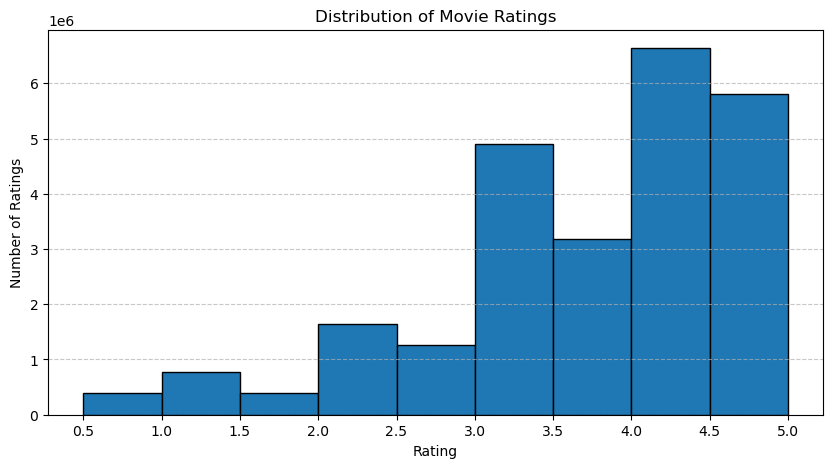

In [7]:
# Distribution of Movie Ratings
plt.figure(figsize=(10, 5))
plt.hist(ratings['rating'], bins=[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], edgecolor='k')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.title('Distribution of Movie Ratings')
plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

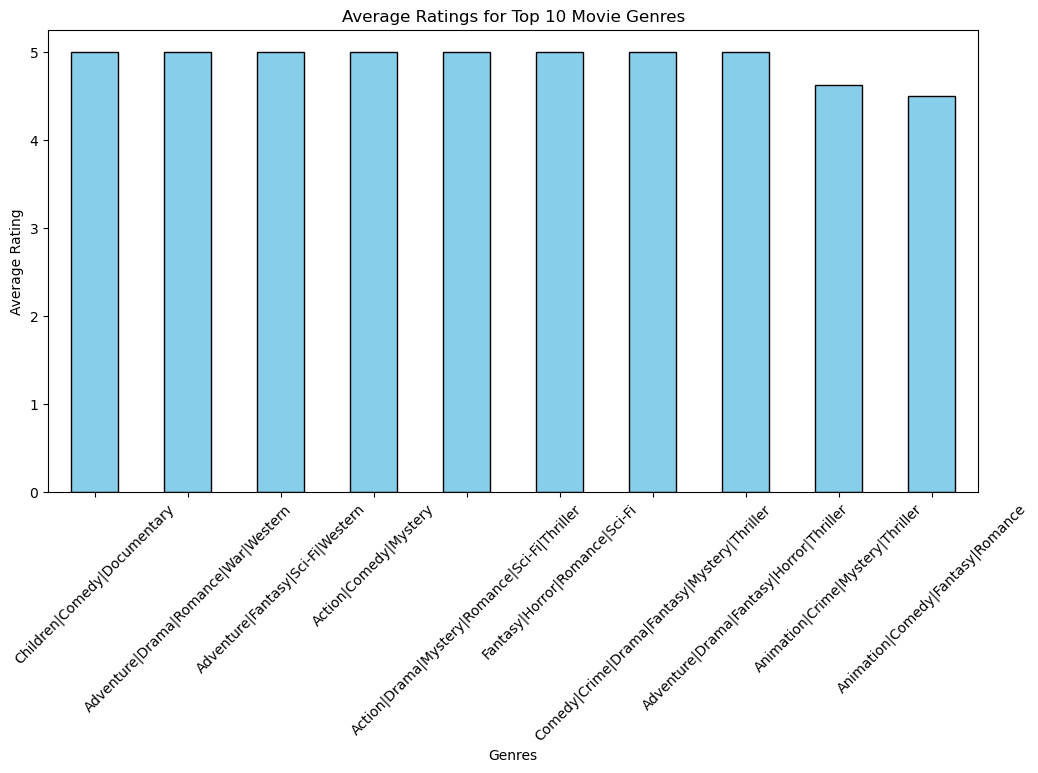

In [8]:
# Average Ratings by Genre
movie_ratings = pd.merge(ratings, movies, on='movieId')
genre_ratings = movie_ratings.groupby('genres')['rating'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
genre_ratings.plot(kind='bar', color='skyblue', edgecolor='k')
plt.xlabel('Genres')
plt.ylabel('Average Rating')
plt.title('Average Ratings for Top 10 Movie Genres')
plt.xticks(rotation=45)
plt.show()

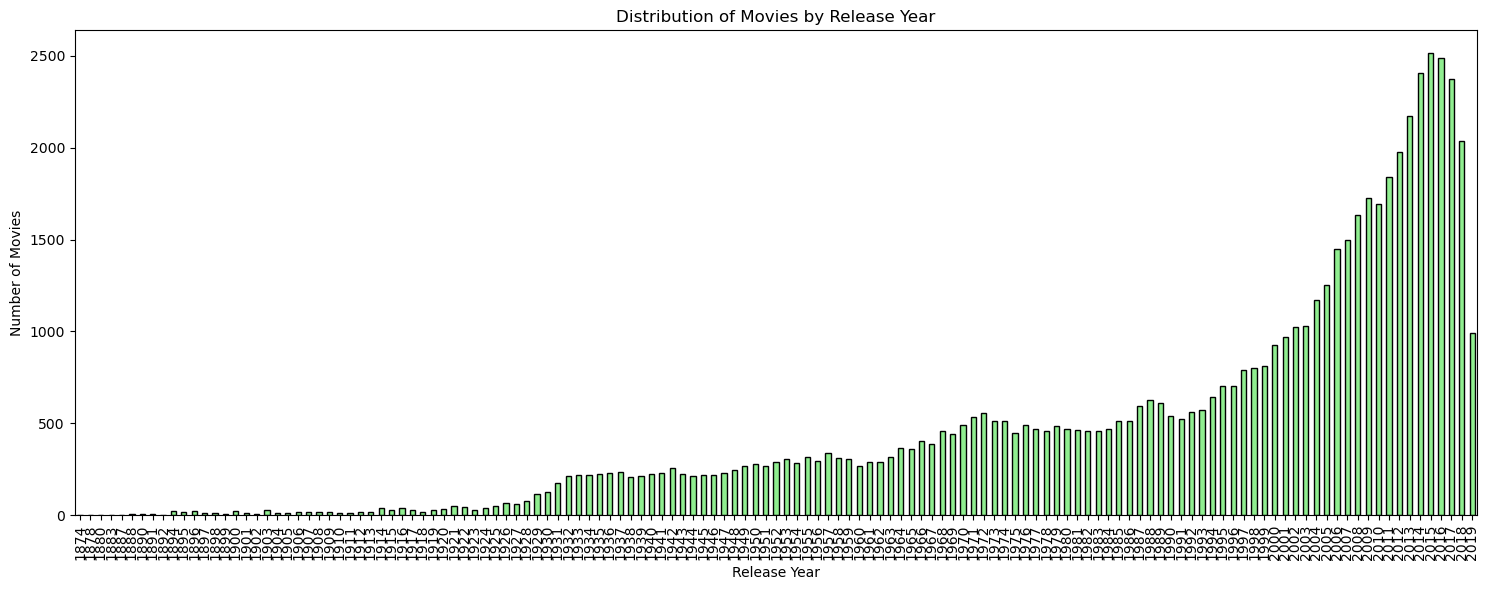

In [9]:
#Movie years release
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')
movie_years = movies['year'].value_counts().sort_index()

plt.figure(figsize=(15, 6))
ax = movie_years.plot(kind='bar', color='lightgreen', edgecolor='k')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies by Release Year')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


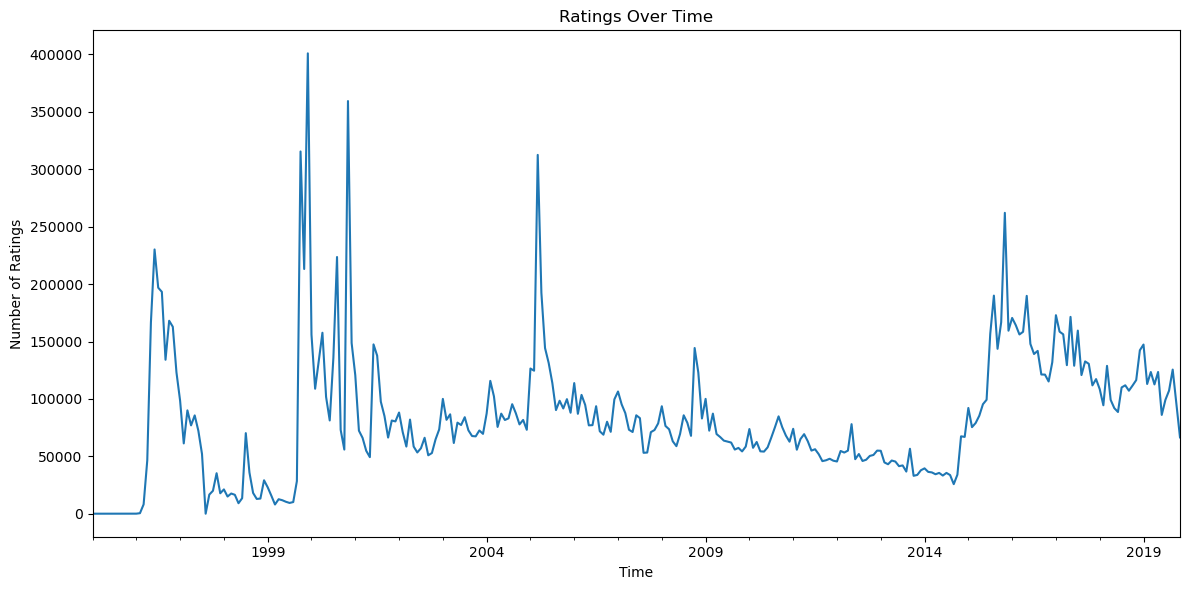

In [10]:
# Number of Ratings Over Time
if 'timestamp' in ratings.columns:
    ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
    ratings.set_index('timestamp', inplace=True)
    ratings['rating'].resample('M').count().plot(figsize=(12, 6))
    plt.xlabel('Time')
    plt.ylabel('Number of Ratings')
    plt.title('Ratings Over Time')
    plt.tight_layout()
    plt.show()
else:
    print("The 'timestamp' column is not present in the ratings DataFrame.")


In [11]:
result = recommend_movies('Toy Story (1995)')
if result and isinstance(result, list):
    print("Recommended Movies:")
    for movie in result:
        print(movie)
else:
    print(result)

Recommended Movies:
Toy Story (1995) (Adventure|Animation|Children|Comedy|Fantasy)
Henry Fool (1997) (Comedy|Drama)
Blame It on Rio (1984) (Comedy|Romance)
Incredibly Strange Creatures Who Stopped Living and Became Mixed-Up Zombies!!?, The (1964) (Horror|Mystery)
Critical Care (1997) (Comedy|Drama)
Warrior, The (2001) (Adventure|Drama)
D.A.R.Y.L. (1985) (Adventure|Children|Sci-Fi)
Voyage of the Damned (1976) (Drama)
Hard Target (1993) (Action|Adventure|Crime|Thriller)
Wild Man Blues (1997) (Documentary)


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have ground truth data and predicted recommendations
ground_truth = ["Movie A", "Movie B", "Movie C", "Movie D", "Movie E"]
predicted_recommendations = ["Movie A", "Movie C", "Movie E", "Movie F", "Movie G"]

# Binary classification: Whether the recommended movies are in the ground truth
y_true = [1 if movie in ground_truth else 0 for movie in predicted_recommendations]
y_pred = [1 if movie in predicted_recommendations else 0 for movie in ground_truth]

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")


Accuracy: 0.60
Precision: 0.67
Recall: 0.67
F1-score: 0.67


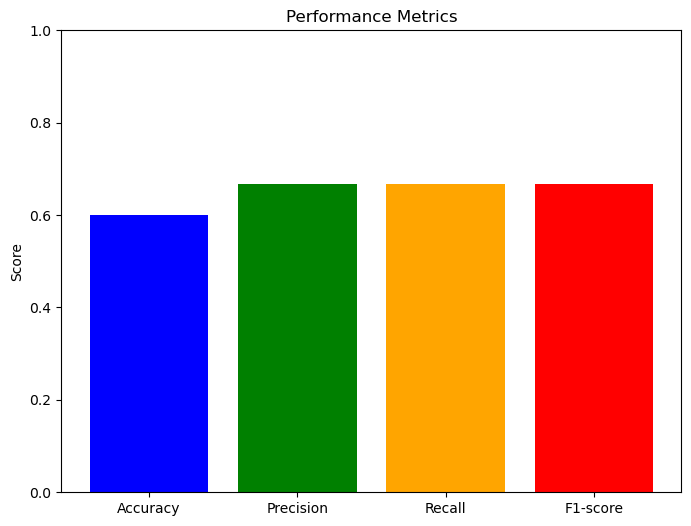

In [13]:
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Visualize the results
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.title('Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for better visualization
plt.show()

In [14]:
pip install scikit-surprise


Note: you may need to restart the kernel to use updated packages.


In [15]:
from surprise import Dataset
from surprise import SVD
from surprise.model_selection import cross_validate

# Load the dataset
data = Dataset.load_builtin('ml-100k')

# Use SVD algorithm
algo = SVD()

# Perform cross-validation
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)




Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9350  0.9389  0.9369  0.9328  0.9414  0.9370  0.0030  
MAE (testset)     0.7387  0.7383  0.7367  0.7358  0.7421  0.7383  0.0022  
Fit time          0.32    0.32    0.32    0.32    0.32    0.32    0.00    
Test time         0.04    0.09    0.03    0.03    0.08    0.05    0.02    


In [16]:
from surprise import Dataset
from surprise import SVD

# Load the dataset (replace 'ml-100k' with your dataset name)
data = Dataset.load_builtin('ml-100k')

# Use SVD algorithm
algo = SVD()

# Fit the model
trainset = data.build_full_trainset()
algo.fit(trainset)

# Create a mapping of movie IDs to movie titles
movie_titles = dict((iid, title) for (iid, title, _) in data.build_full_trainset().all_items())

# Function to recommend movies based on input movie title
def recommend_movies(movie_title):
    # Find the movie ID based on the movie title
    input_movie_id = [item_id for (item_id, title) in movie_titles.items() if title == movie_title]

    # Find the closest movies to the input movie
    if input_movie_id:
        input_movie_id = input_movie_id[0]
        neighbors = algo.get_neighbors(input_movie_id, k=10)
        neighbor_movie_titles = [movie_titles[item_id] for item_id in neighbors]
        return neighbor_movie_titles
    else:
        return ["Movie not found in the dataset."]

# Get recommendations for a specific movie
input_movie = 'Toy Story (1995)'
recommended_movies = recommend_movies(input_movie)
print(f"Recommended movies for '{input_movie}':")
for movie in recommended_movies:
    print(movie)


TypeError: cannot unpack non-iterable int object